## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious  scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [21]:
import pandas           as pd
import numpy            as np
import seaborn          as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.utils import resample

In [4]:
df = pd.read_csv('chronic_kidney_disease_full.csv')

In [5]:
df.shape

(400, 25)

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: I would like to observe that CKD is associated with increasing or decreasing of which attribute

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [6]:
df.isnull().sum().sort_values(ascending = False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

There will be only 158 rows (39.5 %) left in the dataframe
- significant loss of data
- prediction is poor if the percentage of missing values is excessive in comparison to the complete dataset.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

- Minor data loss columns: human error
- Mojor data loss columns: irrelevant data which is not match the purpose of the study \
    (red and white blood cell counts are used to confirm infection )

---
## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: A model telling CKD-patients that they had CKD regardless their lab report. \
(Table highlighted name for CKD status would be great) 

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: Optimize sensivity (recall) and minimize false negatives (error type II)

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: We might get type I error causing panic and unnecessary testing (financial burden) 

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: A model telling non-CKD that they don't have CKD 
(Not highlighted name for non-CKD status would be great) 

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: Optimaized specificity and minimize false positives (type I error)

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: Informing someone with CKD that they are healthy and miss a chance for early treatment.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

### Cleaning

In [7]:
# Drop high data loss percentage columns (loss > 15%)
# df.isnull().sum().sort_values(ascending=False)/len(df)*100
# 'rbc','rbcc','wbcc','pot','sod','pcv','pc'
df.drop(columns=['rbc','rbcc','wbcc','pot','sod','pcv','pc'], inplace=True)

In [8]:
# Drop additional non-relevant columns
df.drop(columns=['ba','pcc','appet'], inplace=True)

In [9]:
# Fill null rows with mean in numerical columns
num_col = ['age','bp','bgr','bu','sc','hemo']
for col in num_col:
    df[col].fillna(df[col].mean(), inplace=True)

In [10]:
# Fill null rows with median in these categorical columns
cat_col = ['sg','al','su']
for col in cat_col:
    df[col].fillna(df[col].median(), inplace=True)

In [11]:
# Fill 'no' in these categorical columns
boo_col = ['htn','dm','cad','pe','ane']
for col in boo_col:
    df[col].fillna('no', inplace=True)

### Dummies columns

In [12]:
df = pd.get_dummies(data =df, columns=['sg','al','su','htn','dm','cad','pe','ane'])
df.shape

(400, 34)

### Train Test Split

In [13]:
X = df.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=69)

In [14]:
sc = StandardScaler()
X_train_sc  = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)
# ====================================
logr = LogisticRegression()
logr.fit(X_train_sc, y_train)

LogisticRegression()

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [15]:
X.columns, logr.coef_.round(3)

(Index(['age', 'bp', 'bgr', 'bu', 'sc', 'hemo', 'sg_1.005', 'sg_1.01',
        'sg_1.015', 'sg_1.02', 'sg_1.025', 'al_0.0', 'al_1.0', 'al_2.0',
        'al_3.0', 'al_4.0', 'al_5.0', 'su_0.0', 'su_1.0', 'su_2.0', 'su_3.0',
        'su_4.0', 'su_5.0', 'htn_no', 'htn_yes', 'dm_no', 'dm_yes', 'cad_no',
        'cad_yes', 'pe_no', 'pe_yes', 'ane_no', 'ane_yes'],
       dtype='object'),
 array([[ 0.309, -0.245, -0.872, -0.524, -0.872,  2.141, -0.114, -1.076,
         -0.877,  0.64 ,  1.185,  0.874, -0.438, -0.338, -0.394, -0.266,
         -0.   ,  0.202, -0.066, -0.163, -0.074, -0.073, -0.007,  0.341,
         -0.341,  0.551, -0.551,  0.058, -0.058,  0.569, -0.569,  0.127,
         -0.127]]))

Age coefficient is 0.309 which means as age increases by one, a person is e^0.309 times as likely to have CKD

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

ane_yes cofficient is -0.127 which means if someone has anemia, he/she/they is e^-0.127 times as likely to have CKD 

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:
- It is easy to understand for non-technical audience similar to Linear Regression
- Easy to implement, interpret, and train

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [16]:
y_pred = logr.predict(X_train_sc)
#=======================================
cm = confusion_matrix(y_train, y_pred)
cm

array([[180,   4],
       [  0, 116]], dtype=int64)

Not that bad, but meh!

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: We cannot optimize both sensitivity and specificity because one score will draw another one down.

Only balanced point of these two is the best option for practical usage

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

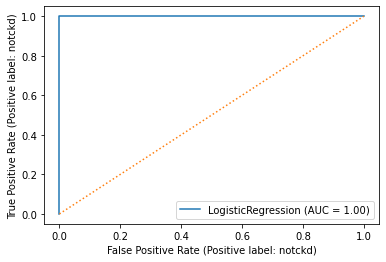

In [17]:
import warnings
warnings.filterwarnings('ignore')

plot_roc_curve(logr, X_test_sc, y_test);
plt.plot([0,1], label='baseline', linestyle=':');

In [18]:
# Not practical use model... 

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: Accuracy score of 100% indicates bad model. There will be an undiagnosed patients by underinvestigating.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: Same thing from 19.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [23]:
dfmaj = df[df['class'] == 'ckd' ]
dfmin = df[df['class'] == 'notckd' ]
#========================================
df_boot = resample(dfmaj, replace = True, n_samples = 4850, random_state = 69)
df_boot = pd.concat([df_boot, dfmin])
#========================================
df_boot['class'].value_counts()

ckd       4850
notckd     150
Name: class, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [32]:
X = df_boot.drop(columns=['class'])
y = df_boot['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 69)
#========================================
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)
#========================================
logr.fit(X_train_sc, y_train)
print(f'Train Score: {logr.score(X_train_sc, y_train).round(3)}')
print(f'Test Score:  {logr.score(X_test_sc, y_test).round(3)}')
#========================================
y_pred = logr.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
cm

Train Score: 0.998
Test Score:  0.999


array([[1216,    0],
       [   1,   33]], dtype=int64)

Unbalanced classes + Logistic Regression affected the specificity of the model (0 False Positive) \
No error type 1 at all might cause underinvestigation in this model

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!